# A Plug-and-Play Suite of Loss Functions for Semantic Segmentation with FastAI
#### TODO- make a pip pipy package...

In [1]:
import torch
from fastai.data.all import *
from fastai.vision.all import *
import optuna
from optuna.integration import FastAIPruningCallback
import optuna.visualization as vs
import fastcore.test as fasttest


## Loss Functions (!!! The model has NO softmax !!! You must provide your own in the loss fn)


### New Loss Functions

In [2]:
class ModifiedTverskyLoss:
    """
    Modified Tversky Loss
    proposed in https://arxiv.org/abs/1706.05721
    based on FastAI's dice loss implementation
    Beta of 0.5 should equal dice loss exactly,
    but fastai's inbuilt dice is preferred because it requires less computation.
    Modified to be analytically equal to dice, even with smoothing
    """
    def __init__(self, 
        axis:int=1, # Class axis
        smooth:float=1e-6, # Helps with numerical stabilities in the IoU division
        reduction:str="sum", # PyTorch reduction to apply to the output
        beta = 0.5 # makes dice by default...
    ):
        store_attr()
        
    def __call__(self, pred:Tensor, targ:Tensor) -> Tensor:
        """One-hot encodes targ, then takes tversky index"""
        targ = self._one_hot(targ, pred.shape[self.axis])
        pred, targ = TensorBase(pred), TensorBase(targ)
        assert pred.shape == targ.shape, 'input and target dimensions differ, Tversky expects non one-hot targs'
        pred = self.activation(pred)
        sum_dims = list(range(2, len(pred.shape)))
        #set operations
        inter = torch.sum(pred*targ, dim=sum_dims)
        pred_not_in_targ = torch.sum((1-targ)*pred, dim=sum_dims) # relative complements
        targ_not_in_pred = torch.sum((1-pred)*targ, dim=sum_dims)
        # calculate index
        num = inter
        denom = inter + self.beta*pred_not_in_targ + (1-self.beta)*targ_not_in_pred #TODO check for reversing...
        tversky_index = (num + (self.smooth/2))/(denom + (self.smooth/2))
        #get loss
        loss = 1 - tversky_index
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        return loss
    @staticmethod
    def _one_hot(
        x:Tensor, # Non one-hot encoded targs
        classes:int, # The number of classes 
        axis:int=1 # The axis to stack for encoding (class dimension)
    ) -> Tensor:
        """Creates one binary mask per class"""
        return torch.stack([torch.where(x==c, 1, 0) for c in range(classes)], axis=axis)
    
    def activation(self, x:Tensor) -> Tensor: 
        """Activation function applied to model output"""
        return F.softmax(x, dim=self.axis)
    
    def decodes(self, x:Tensor) -> Tensor:
        """Converts model output to target format"""
        return x.argmax(dim=self.axis)

### Loss Classes

In [3]:
class SimpleDiceLoss:
    """
    A wrapper around fastai's Dice Loss.
    Proposed in [SOURCE]
    """
    def __init__(self, axis=1, smooth=1.):
        store_attr()
        self.dice_loss =  DiceLoss(axis, smooth, reduction="sum")
        
    def __call__(self, pred, targ):
        return self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)
    # This works because fastai yoinks it using getcallable, a wrapper for getattr
    # only the definition inside the outer class actually used matters!

In [4]:
class ComboLoss: 
    """
    Dice and Cross Entropy Loss combined
    Proposed in [SOURCE]
    """
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.ce_loss = CrossEntropyLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth, reduction="sum")
        
    def __call__(self, pred, targ):
        return alpha * self.ce_loss(pred, targ) + (1-alpha)*self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [5]:
class FocalDiceLoss: # example class building on dice loss
    """
    Dice and Focal Loss combined
    proposed in [SOURCE]
    """
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth, reduction="sum")
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [6]:
class FocalTverskyLoss:
    """
    Tversky and Focal Loss combined
    proposed in [SOURCE]
    Fundementally different from FocalDiceLoss?? (we shall see)
    """
    def __init__(self, axis=1, smooth=1., alpha=1., beta=0.5):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.tversky_loss =  ModifiedTverskyLoss(axis, smooth, reduction="sum")#, beta=beta) #TODO-- fix param passing
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.tversky_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [7]:
class LogCoshDiceLoss:
    """
    proposed in http://arxiv.org/abs/2006.14822
    """
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.dice_loss =  DiceLoss(axis, smooth, reduction="sum")
        
    def __call__(self, pred, targ):
        x = self.dice_loss(pred, targ)
        return torch.log(torch.cosh(x))
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

## Testing

### Loss Test Suite

In [8]:
#Test
model_output = tensor([[[[2., 1.],
                         [1., 5.]],
                        [[1,  2.],
                         [3., 1.]],
                        [[3., 0],
                         [4., 3.]]]])
target       =  tensor([[[2, 1],
                         [2, 0]]])
# [B, N, W, H]
# [B, W, H]

#losses
##cel = CrossEntropyLossFlat()
fl = FocalLossFlat(axis=1)

dl = DiceLoss(reduction="sum", smooth=1.) #THIS MUST BE 1 to MATCH ANYTHING
tl = ModifiedTverskyLoss(reduction="sum", smooth=1., beta=0.5) # AND THIS YOU IDIOT

fdl = FocalDiceLoss()
ftl = FocalTverskyLoss(beta=0.5)

#outputs
##cel_out = cel(model_output, target)
fl_out = fl(model_output, target)



dl_out = dl(model_output, target)
tl_out = tl(model_output, target)

fdl_out = fdl(model_output, target)
ftl_out = ftl(model_output, target)

#tests

fasttest.test_close(dl_out, SimpleDiceLoss()(model_output, target)) # juuust in case

fasttest.test_close(fl_out + dl_out, fdl_out) #fdl is just fl+dl... but its less for some reason

fasttest.test_close(dl_out, tl_out) # should be the same if the tversky beta = 0.5

fasttest.test_close(fdl_out, ftl_out)



# something fishy is happening here....

### Test on Model

In [9]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

In [12]:
#loss_func = DiceFocalLoss()
#loss_func = BaseLoss(DiceLoss, axis=1, smooth=1, reduction="mean")#, square_in_union=True) #dice loss is naturally unsmooth
#loss_func = DiceLoss(axis=1, smooth=1) #dice loss is naturally unsmooth

#loss_func = CrossEntropyLossFlat(axis=1)
#loss_func = SimpleDiceLoss()
#loss_func = DiceCELoss()
#loss_func = LogCoshDiceLoss()

#loss_func = CrossEntropyLossFlat(axis=1)

loss_func = ModifiedTverskyLoss(reduction="mean")

learn = unet_learner(dls, resnet34, loss_func = loss_func, metrics=DiceMulti(axis=1))
# lr = learn.lr_find()

epoch,train_loss,valid_loss,dice_multi,time
0,0.984282,0.972029,0.041661,00:01


epoch,train_loss,valid_loss,dice_multi,time
0,0.964824,0.956693,0.048552,00:01
1,0.955230,0.936622,0.085277,00:01
2,0.942116,0.926758,0.085484,00:01
3,0.933167,0.921467,0.093063,00:01


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

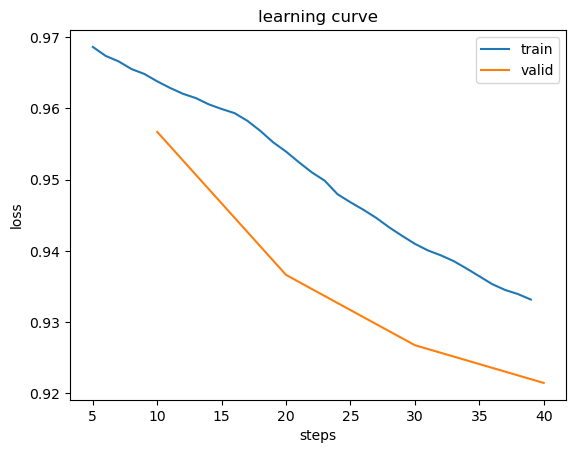

In [13]:
learn.fine_tune(4, 10e-5) # 10e-5 works
learn.recorder.plot_loss()